#Brad's Code for Better Simulations

In [2]:
require(mvtnorm)
require(Matrix)
require(arm)
require(ggplot2)
n <- 1e4
sims <- 1e3

Loading required package: mvtnorm
Warning message:
: package 'mvtnorm' was built under R version 3.2.1Loading required package: Matrix
Warning message:
: package 'Matrix' was built under R version 3.2.1Loading required package: arm
Warning message:
: package 'arm' was built under R version 3.2.1Loading required package: MASS
Warning message:
: package 'MASS' was built under R version 3.2.1Loading required package: lme4
Warning message:
: package 'lme4' was built under R version 3.2.1
arm (Version 1.8-5, built: 2015-05-13)

Working directory is C:/Users/Jonathan/Documents/IPython Notebooks

Loading required package: ggplot2
Warning message:
: package 'ggplot2' was built under R version 3.2.1

## Make a Varianc-Covariance Matrix

In [3]:
sigma <- matrix(runif(25,-1,1), 5,5)
sigma <- as.matrix(forceSymmetric(sigma))

In [4]:
length(sigma)

[1] 25

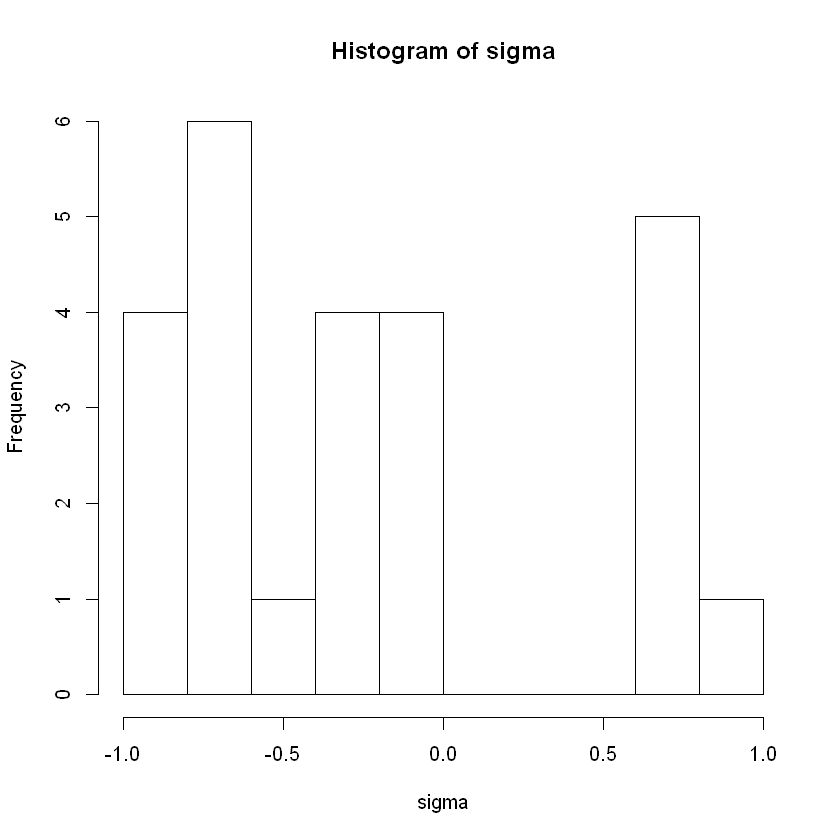

In [5]:
hist(sigma, breaks=10)

## Simulate some X's

In [7]:
y <- rbinom(n,1,.5)
x <- matrix(NA, n,5)

In [8]:
x[y==1,] <- rmvnorm(n = sum(y==1), mean = 1:5, sigma =  sigma, method='svd')

In [9]:
x[y==0,] <- rmvnorm(n = sum(y==0), mean = c(1:5), sigma =  sigma, method='svd')
dat <- data.frame(y,x)

In [10]:
str(dat)

'data.frame':	10000 obs. of  6 variables:
 $ y : int  1 1 1 1 1 0 0 1 0 0 ...
 $ X1: num  2.706 0.095 -0.751 2.03 1.421 ...
 $ X2: num  2.184 2.337 3.492 1.173 0.292 ...
 $ X3: num  1.77 3.22 3.11 1.48 6.02 ...
 $ X4: num  4.2 4.87 5.02 3.83 3.82 ...
 $ X5: num  6.28 6.6 4.22 3.95 6.12 ...


#Add an Intercept Column for scoring later then Estimate a model, simulate coefficients

In [11]:
x <- cbind(1,x)
m1 <- glm(y~., data=dat, family=binomial)

In [12]:
summary(m1)
summary(x)


Call:
glm(formula = y ~ ., family = binomial, data = dat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.256  -1.181   1.122   1.173   1.246  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.279032   0.130810   2.133   0.0329 *
X1           0.030421   0.023989   1.268   0.2047  
X2           0.015233   0.025925   0.588   0.5568  
X3           0.006789   0.020159   0.337   0.7363  
X4          -0.042579   0.034146  -1.247   0.2124  
X5          -0.035977   0.017710  -2.031   0.0422 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13863  on 9999  degrees of freedom
Residual deviance: 13857  on 9994  degrees of freedom
AIC: 13869

Number of Fisher Scoring iterations: 3


       V1          V2                V3               V4        
 Min.   :1   Min.   :-3.3807   Min.   :-1.921   Min.   :-1.082  
 1st Qu.:1   1st Qu.: 0.2357   1st Qu.: 1.226   1st Qu.: 2.268  
 Median :1   Median : 1.0005   Median : 1.997   Median : 3.019  
 Mean   :1   Mean   : 1.0007   Mean   : 2.000   Mean   : 3.026  
 3rd Qu.:1   3rd Qu.: 1.7792   3rd Qu.: 2.773   3rd Qu.: 3.793  
 Max.   :1   Max.   : 5.1591   Max.   : 6.167   Max.   : 7.465  
       V5                V6        
 Min.   :-0.2508   Min.   :0.6116  
 1st Qu.: 3.3430   1st Qu.:4.2187  
 Median : 4.0003   Median :5.0217  
 Mean   : 4.0033   Mean   :5.0147  
 3rd Qu.: 4.6720   3rd Qu.:5.8065  
 Max.   : 8.0702   Max.   :9.7111  

In [13]:
simulated.coefs <- rmvnorm(n = sims, mean = m1$coefficients, sigma = vcov(m1), method='svd')

In [14]:
score = function(i) invlogit(x %*% i )
    str(simulated.coefs)
    str(x)

 num [1:1000, 1:6] 0.238 0.396 -0.056 0.146 0.135 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:6] "(Intercept)" "X1" "X2" "X3" ...
 num [1:10000, 1:6] 1 1 1 1 1 1 1 1 1 1 ...


In [15]:
yhat <- apply(simulated.coefs, 1, score)

In [17]:
str(yhat)

 num [1:10000, 1:1000] 0.486 0.503 0.515 0.515 0.501 ...


## Let's look at the distribution of yhat for observation 1 and compare it to a variance-only estimate

In [19]:
plot.df <- data.frame(type = "Variance-Covariance Matrix", yhat = yhat[1,])

## Now what if we had ignored the covariance of the coefficients and just used the coefficient's variance?

In [21]:
sigma.wrongway <- vcov(m1)
sigma.wrongway[upper.tri(sigma.wrongway) | lower.tri(sigma.wrongway)] <- 0

simulated.coefs.wrongway <- rmvnorm(n = sims, mean = m1$coefficients, sigma = sigma.wrongway)
yhat.wrongway <- apply(simulated.coefs.wrongway, 1, score)

## For funsies, let's look at the distribution of yhat for observation 1

In [30]:
plot.df <- rbind(plot.df, data.frame(type = "Variances Only", yhat = yhat.wrongway[3,]))

p <- ggplot(plot.df, aes(x=yhat, colour = type)) + 
  geom_density() +
  theme_bw()



In [32]:
sd(yhat.wrongway[1,]) > sd(yhat[1,])

[1] TRUE

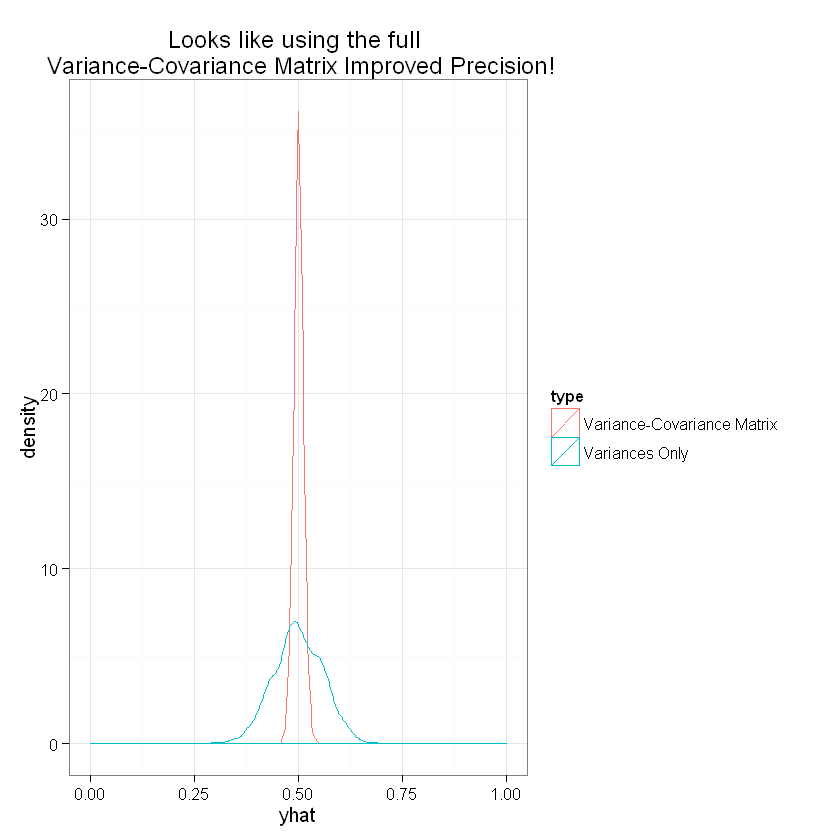

In [35]:
p+ ggtitle("Looks like using the full \n Variance-Covariance Matrix Improved Precision!") +
xlim(0,1)